<a href="https://colab.research.google.com/github/Ersel26/echo_KVAK/blob/main/echo_KVAK_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.applications import EfficientNetB3
from keras.applications import EfficientNetB0
from keras.models import Sequential

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DIRECTORY = r"/content/drive/MyDrive/Echo_KVAK/labeled data"
IMG_SIZE = 299 # for InceptionV3
BATCH_SIZE = 256
NUM_CLASSES = len(os.listdir(DIRECTORY))

In [2]:
def create_data_ImageDataGenerator(data_gen, data_dir):
  train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
  ) 
  validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation')  # set as validation data
  return (train_generator, validation_generator)

In [7]:
data_gen = ImageDataGenerator(
        # rotation_range=40,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

(train_generator, validation_generator) = create_data_ImageDataGenerator(data_gen, DIRECTORY)

Found 9213 images belonging to 7 classes.
Found 2302 images belonging to 7 classes.


In [ ]:
def label_dist(generator):
  first = 0
  second = 0
  third = 0
  fourth = 0
  fifth = 0
  sixth = 0
  seventh = 0
  total = 0

  for i, batch in enumerate(generator):
      images, labels = batch
      
      for label in labels:
        if (label[0] == 1.0):
          first += 1
        elif (label[1] == 1.0):
          second += 1
        elif (label[2] == 1.0):
          third += 1
        elif (label[3] == 1.0):
          fourth += 1
        elif (label[4] == 1.0):
          fifth += 1
        elif (label[5] == 1.0):
          sixth += 1
        elif (label[6] == 1.0):
          seventh += 1
        total += 1

      if i == 10:
        break

  print("{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f}, {5:.2f}, {6:.2f}".format(first/total, second/total, third/total, fourth/total, fifth/total, sixth/total, seventh/total))

label_dist(train_generator)
label_dist(validation_generator)

0.13, 0.03, 0.30, 0.06, 0.05, 0.28, 0.14
0.13, 0.03, 0.29, 0.09, 0.10, 0.27, 0.10


#EfficientNETB0 with initial weights and w/o data augmentation

In [ ]:
efficient_net = EfficientNetB0(
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    include_top=False,
    pooling='max',
    
)

model = tf.keras.models.Sequential()
model.add(efficient_net)
model.add(layers.Dense(units = 120, activation='relu'))
model.add(layers.Dense(units = 120, activation = 'relu'))
model.add(layers.Dense(units = NUM_CLASSES, activation='sigmoid'))
model.summary()

optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"] )

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_75 (Dense)            (None, 120)               153720    
                                                                 
 dense_76 (Dense)            (None, 120)               14520     
                                                                 
 dense_77 (Dense)            (None, 7)                 847       
                                                                 
Total params: 4,218,658
Trainable params: 4,176,635
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator, 
    epochs = 30,
    validation_data = validation_generator, 
    verbose = 1,
    steps_per_epoch = 36,
    validation_steps = 8,
    )

Epoch 1/30
36/36 [==============================] - 64s 2s/step - loss: 4.4865 - accuracy: 0.4478 - val_loss: 37532.1719 - val_accuracy: 0.2915
Epoch 2/30
36/36 [==============================] - 52s 1s/step - loss: 1.0407 - accuracy: 0.6339 - val_loss: 2730.8076 - val_accuracy: 0.2412
Epoch 3/30
36/36 [==============================] - 52s 1s/step - loss: 0.8582 - accuracy: 0.7129 - val_loss: 43.2881 - val_accuracy: 0.2900
Epoch 4/30
36/36 [==============================] - 52s 1s/step - loss: 0.7680 - accuracy: 0.7372 - val_loss: 88.9177 - val_accuracy: 0.2363
Epoch 5/30
36/36 [==============================] - 52s 1s/step - loss: 0.6849 - accuracy: 0.7660 - val_loss: 22.6456 - val_accuracy: 0.2417
Epoch 6/30
36/36 [==============================] - 52s 1s/step - loss: 0.6484 - accuracy: 0.7827 - val_loss: 1.9947 - val_accuracy: 0.2407
Epoch 7/30
36/36 [==============================] - 52s 1s/step - loss: 0.6173 - accuracy: 0.7994 - val_loss: 2.2267 - val_accuracy: 0.0293
Epoch 8/30

KeyboardInterrupt: ignored

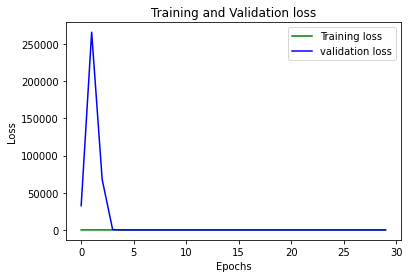

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

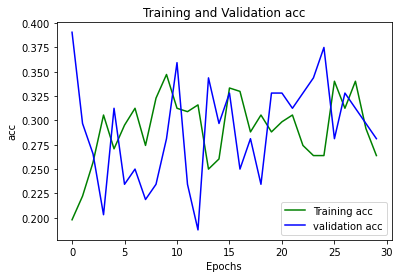

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

# InceptionV3 with initial weights and w/o augmentation

In [8]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    weights='imagenet',
    input_tensor=None,
    pooling='max',
    classes=1000,
    classifier_activation='softmax'
)

model = tf.keras.models.Sequential()
model.add(inception)
model.add(layers.Dense(units = 128, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(units = 64, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(units = 32, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(units = NUM_CLASSES, activation='softmax'))
model.summary()

optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"] )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
history = model.fit(
    train_generator, 
    epochs = 30,
    validation_data = validation_generator, 
    verbose = 1,
    steps_per_epoch = 36,
    validation_steps = 8,
    )

Epoch 1/30
36/36 [==============================] - 889s 24s/step - loss: 1.7914 - accuracy: 0.2843 - val_loss: 1.7767 - val_accuracy: 0.2988
Epoch 2/30
36/36 [==============================] - 873s 24s/step - loss: 1.7020 - accuracy: 0.3553 - val_loss: 1.7939 - val_accuracy: 0.3008
Epoch 3/30
36/36 [==============================] - 868s 24s/step - loss: 1.5440 - accuracy: 0.4703 - val_loss: 2.7515 - val_accuracy: 0.2979
Epoch 4/30
36/36 [==============================] - 869s 24s/step - loss: 1.4267 - accuracy: 0.4982 - val_loss: 2.6343 - val_accuracy: 0.2944
Epoch 5/30


KeyboardInterrupt: ignored

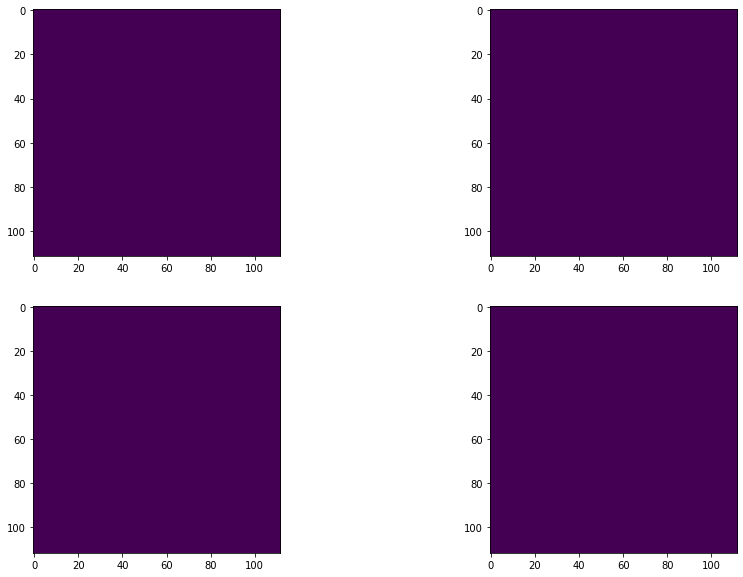

In [ ]:
rows = 2
columns = 2
fig, axes = plt.subplots(rows,columns)
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next()[0]
        image = image_batch[0].astype('uint8')*255
        axes[r,c].imshow(image)
fig.set_size_inches(15,10)

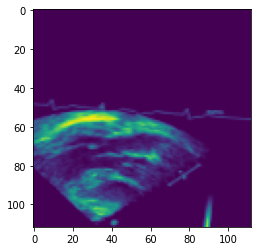

In [ ]:
train_images, train_labels = next(train_generator)
plt.imshow(train_images[15])

In [ ]:
efficient_net = EfficientNetB3(
    weights=None,
    input_shape=(IMG_SIZE,IMG_SIZE,1),
    include_top=False,
    pooling='max'
)

model = tf.keras.models.Sequential()
model.add(efficient_net)
model.add(layers.Dense(units = 120, activation='relu'))
model.add(layers.Dense(units = 120, activation = 'relu'))
model.add(layers.Dense(units = NUM_CLASSES, activation='sigmoid'))
model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10782811  
                                                                 
 dense (Dense)               (None, 120)               184440    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 7)                 847       
                                                                 
Total params: 10,982,618
Trainable params: 10,895,319
Non-trainable params: 87,299
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = validation_generator,
    validation_steps = 7
)

Epoch 1/50
15/15 [==============================] - 98s 7s/step - loss: 1.7541 - accuracy: 0.2896 - val_loss: 1.7709 - val_accuracy: 0.2768
Epoch 2/50
15/15 [==============================] - 90s 6s/step - loss: 1.7880 - accuracy: 0.2771 - val_loss: 1.8150 - val_accuracy: 0.2545
Epoch 3/50
15/15 [==============================] - 76s 5s/step - loss: 1.7600 - accuracy: 0.2704 - val_loss: 1.7723 - val_accuracy: 0.2500
Epoch 4/50
15/15 [==============================] - 76s 5s/step - loss: 1.7735 - accuracy: 0.2896 - val_loss: 1.7473 - val_accuracy: 0.2946
Epoch 5/50
15/15 [==============================] - 66s 4s/step - loss: 1.7521 - accuracy: 0.3250 - val_loss: 1.7684 - val_accuracy: 0.2723
Epoch 6/50
15/15 [==============================] - 69s 5s/step - loss: 1.7585 - accuracy: 0.3000 - val_loss: 1.8315 - val_accuracy: 0.2366
Epoch 7/50
15/15 [==============================] - 57s 4s/step - loss: 1.7782 - accuracy: 0.2875 - val_loss: 1.7869 - val_accuracy: 0.2277
Epoch 8/50
15/15 [==

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


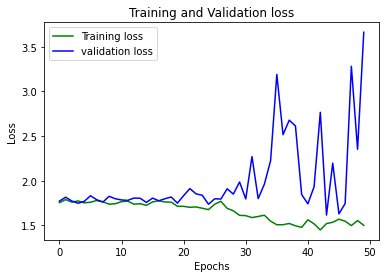

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

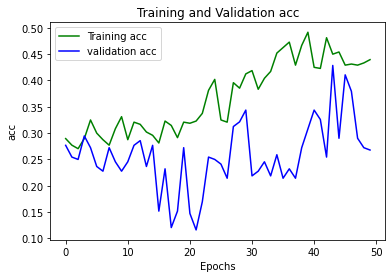

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()